# Forecast Hybrid Production Notebook
Author: George Panagiotou

# Forecasting track

In [1]:
import pandas as pd
import numpy as np
from comp_utils import *
import os
import os
import joblib
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_pinball_loss
from concurrent.futures import ThreadPoolExecutor, as_completed

## Test and train data:

In [2]:
Wind_train = pd.read_csv('data/LinearQ/Wind_train_quantiles.csv')
Wind_train = Wind_train.rename(columns={'q10': 'qw10','q20': 'qw20','q30': 'qw30','q40': 'qw40','q50': 'qw50','q60': 'qw60','q70': 'qw70','q80': 'qw80','q90': 'qw90' }) 

Solar_train = pd.read_csv('data/LinearQ/Solar_train_quantiles.csv')
Solar_train = Solar_train.rename(columns={'q10': 'qs10','q20': 'qs20','q30': 'qs30','q40': 'qs40','q50': 'qs50','q60': 'qs60','q70': 'qs70','q80': 'qs80','q90': 'qs90' }) 

Train_set = Solar_train.merge(Wind_train, on='time')

train_target_variable = Train_set['Wind_MWh_credit']+Train_set['Solar_MWh_credit']
Train_set = Train_set.rename(columns={'time':'valid_time'})
Train_set['valid_time'] = pd.to_datetime(Train_set['valid_time'])
train_times = Train_set['valid_time']
Train_set = add_cyclic_features(Train_set)
Train_set = Train_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Train features after removing columns:', Train_set.shape)

Wind_test = pd.read_csv('data/LinearQ/Wind_test_quantiles.csv')
Wind_test = Wind_test.rename(columns={'q10': 'qw10','q20': 'qw20','q30': 'qw30','q40': 'qw40','q50': 'qw50','q60': 'qw60','q70': 'qw70','q80': 'qw80','q90': 'qw90' }) 

Solar_test = pd.read_csv('data/LinearQ/Solar_test_quantiles.csv')
Solar_test = Solar_test.rename(columns={'q10': 'qs10','q20': 'qs20','q30': 'qs30','q40': 'qs40','q50': 'qs50','q60': 'qs60','q70': 'qs70','q80': 'qs80','q90': 'qs90' }) 

Test_set = Solar_test.merge(Wind_test, on='time')
test_target_variable = Test_set['Wind_MWh_credit']+Test_set['Solar_MWh_credit']
Test_set = Test_set.rename(columns={'time':'valid_time'})
Test_set['valid_time'] = pd.to_datetime(Test_set['valid_time'])
test_times = Test_set['valid_time']
Test_set = add_cyclic_features(Test_set)
Test_set = Test_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Test features after removing columns:', Test_set.shape)

Train features after removing columns: (56284, 27)
Test features after removing columns: (4318, 27)


### LQR (Training)
!!! DO NOT RUN !!!

In [5]:
# Quantiles for the models
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
last_quantile_losses = {} 

def train_and_save_model(quantile):
    print(f"Training model for quantile {quantile}...")
    
    model = QuantileRegressor(quantile=quantile, alpha=0.1)
    
    # Fit the model
    model.fit(Train_set, train_target_variable)
    
    # Save the model
    model_path = f'models/LinearQ/LQR_W&S_q{int(quantile * 100)}.joblib'
    joblib.dump(model, model_path)

    # Calculate the pinball loss for the training set
    predictions = model.predict(Train_set)
    last_loss = mean_pinball_loss(train_target_variable, predictions, alpha=quantile)
    
    print(f"Finished training model for quantile {quantile}. Last training loss: {last_loss}")  # Print statement after training
    return quantile, last_loss

# Using ThreadPoolExecutor to parallelize the training
with ThreadPoolExecutor(max_workers=len(quantiles)) as executor:
    futures = {executor.submit(train_and_save_model, quantile): quantile for quantile in quantiles}
    for future in as_completed(futures):
        quantile, last_loss = future.result()
        last_quantile_losses[quantile] = last_loss

# Print the last training loss for each quantile after all models have been trained
for quantile, last_loss in last_quantile_losses.items():
    print(f"Last training loss for quantile {quantile}: {last_loss}")


Training model for quantile 0.1...
Training model for quantile 0.2...
Training model for quantile 0.3...
Training model for quantile 0.4...
Training model for quantile 0.5...
Training model for quantile 0.6...
Training model for quantile 0.7...
Training model for quantile 0.8...
Training model for quantile 0.9...
Finished training model for quantile 0.6. Last training loss: 44.652904279996434
Finished training model for quantile 0.2. Last training loss: 32.34063999661809
Finished training model for quantile 0.1. Last training loss: 20.43804823145483
Finished training model for quantile 0.5. Last training loss: 46.09546206545055
Finished training model for quantile 0.3. Last training loss: 40.1534937703987
Finished training model for quantile 0.9. Last training loss: 20.34801053151292
Finished training model for quantile 0.7. Last training loss: 40.23726394837398
Finished training model for quantile 0.8. Last training loss: 32.44767581906421
Finished training model for quantile 0.4. Las

In [4]:
# Initialize dictionary to store predictions
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = train_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0 
    model_path = f'models/LinearQ/LQR_W&S_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Train_set)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

print('Training Loss(Quantile):',pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

Training Loss(Quantile): 35.69565989769873


In [5]:
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

# Define the quantiles
quantiles = range(10, 100, 10)

# Load models and predict
for qu in quantiles:
    quantile = qu / 100.0 
    model_path = f'models/LinearQ/LQR_W&S_q{int(quantile * 100)}.joblib'
    model = joblib.load(model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Test_set)

# Create DataFrame from predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure predictions are non-negative
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

print('Test Loss(Quantile):',pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

Test Loss(Quantile): 31.624934814517005


## Plot Quantiles ( Probabilistic Forecasting) : 

In [6]:
save_path = "plots/LinearQ/W&S_LQR_Plot.html"
graph_title = "Hybrid Production Forecast (LQR)"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'total_generation_MWh', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

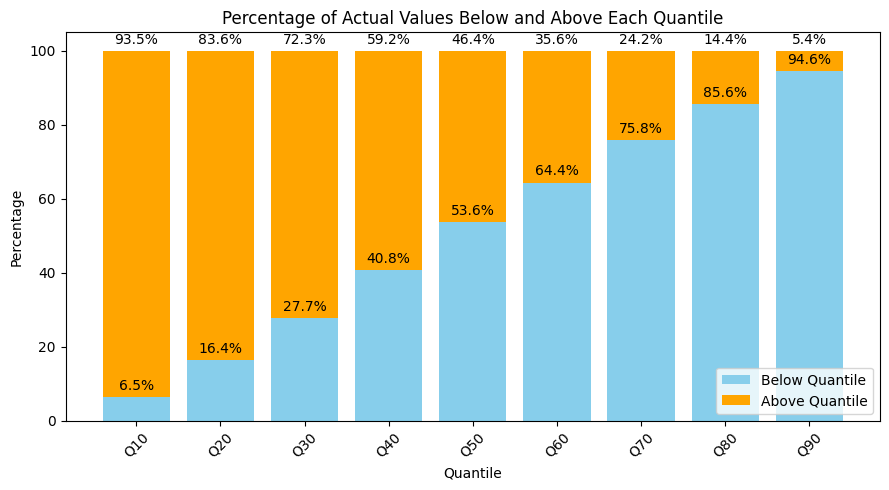

In [7]:
quantile_stats(quantile_predictions_df)

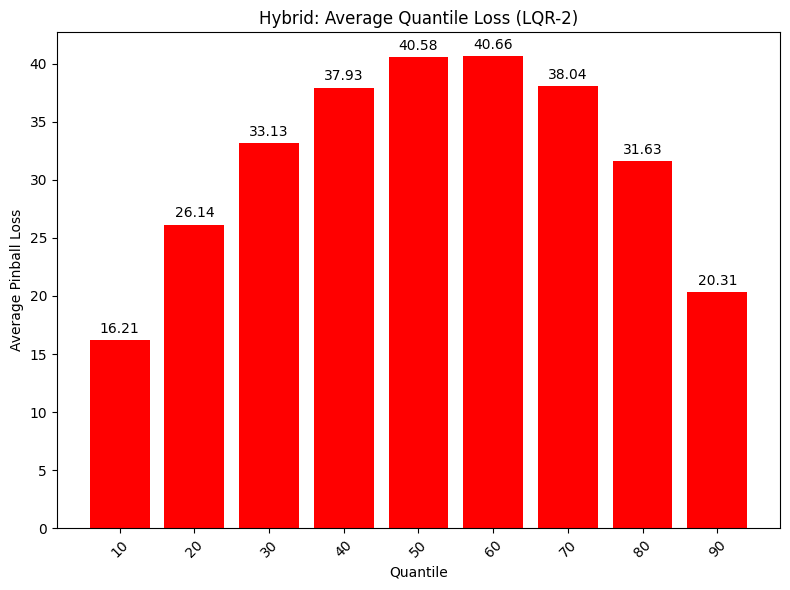

In [9]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'total_generation_MWh', "Hybrid: Average Quantile Loss (LQR-2)")